In [1]:
import pandas as pd
import numpy as np

# calculating RSI (gives the same values as TradingView)
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
def RSI(series, period=14):
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - 100 / (1 + rs)


# calculating Stoch RSI (gives the same values as TradingView)
# https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D


# calculating Stoch RSI 
#  -- Same as the above function but uses EMA, not SMA
def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D

In [2]:
# FUNCTIONS

# Performs the logic for joining over all the bearish indicators
def tf_bear(x, tf, lens):
    return 1 if (x.close < x[[tf + "_" + str(l) for l in lens]]).all() else 0

# Performs the logic for joining over all the bullish indicators
def tf_bull(x, tf, lens):
    return 1 if (x.close > x[[tf + "_" + str(l) for l in lens]]).all() else 0

# EWMA formula
def numpy_ewma_vectorized(data, window):
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out


In [4]:
# CONFIGURATIONS
# File with OHLC data
HISTORICAL_DATA_FILE = "/Users/blagovestvelev/ETHUSDT/minute/ETHUSDT.csv"
# Define lengths for all the EMAS (in periods regardless of what the underlying granularity is)
LENS = [9, 21, 34, 50, 89, 100, 150, 200]

# Different time frames
# TIME_FRAMES = {
#     'five': '5min',
#     'fifteen': '15min',
#     'hourly': '1H'
# }
base_minutes = 23

S_PERIOD_PARAM = 12
M_PERIOD_PARAM = 48
L_PERIOD_PARAM = 177

TIME_FRAMES = {
    's': str(base_minutes*S_PERIOD_PARAM) + 'min',
    'm': str(base_minutes*M_PERIOD_PARAM) + 'min',
    'l':str(base_minutes*L_PERIOD_PARAM) + 'min'
}

In [433]:
# LOADING THE RAW DATA
# [!NOTE] This can be done once as it's later processed and can be pickl-ed
df = pd.read_csv(
    HISTORICAL_DATA_FILE)

# Sort out the Binance timestamp
df['date'] = df['date'].apply(lambda x: pd.Timestamp(x * 1000 * 1000))
# df['date'] = df['date'].apply(lambda x: pd.Timestamp(x))
df.index = df['date']
# Filter out columns
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

df = df.sort_index()

# RESAMPLING OF DATA
alternate_dfs = {}
for k, v in TIME_FRAMES.items():
    alternate_dfs[k] = df.resample(v).agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last'}).copy()


df = df.resample(str(base_minutes) + "min").agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last'})
# df = df.iloc[-400000:]

In [434]:
# CALCULATE THE INDICATORS
# This takes a while to complete

# Can be increased or decreased depending on how much data we want to used for the backtest
MINUTES = len(df.index)#1440*7*80 
# MINUTES = 5000
for i in alternate_dfs.keys():
    for l in LENS:
        df[i+"_"+str(l)] = np.nan

cc = 0
# Calculate all the emas on the different granularities at each minute
for x in df.index[-MINUTES:]:
    cc+=1
    if cc % 1000 == 0:
        print(cc, MINUTES)
    for adf_k in alternate_dfs.keys():
        working_data = alternate_dfs[adf_k][alternate_dfs[adf_k].index < x].iloc[-max(LENS):]
        if len(working_data.index) < max(LENS):
            break
        for _l in LENS:
            _l_data = working_data[-_l:]
            arr = np.append(_l_data.close.values, df.loc[x].close)
            df.at[x, adf_k + "_" + str(_l)] = numpy_ewma_vectorized(arr , _l)[-1]


# Calculate the indicators at each minute
for tf in alternate_dfs.keys():
    df[f"tf_{tf}_bear"] = df.dropna().apply(lambda x: tf_bear(x, tf, LENS), axis=1)
    df[f"tf_{tf}_bull"] = df.dropna().apply(lambda x: tf_bull(x, tf, LENS), axis=1)


df['bearish_indicator'] = -np.floor(df[[f"tf_{tf}_bear" for tf in alternate_dfs.keys()]].sum(axis=1)/len(alternate_dfs.keys()))
df['bullish_indicator'] = np.floor(df[[f"tf_{tf}_bull" for tf in alternate_dfs.keys()]].sum(axis=1)/len(alternate_dfs.keys()))

1000 66679
2000 66679
3000 66679
4000 66679
5000 66679
6000 66679
7000 66679
8000 66679
9000 66679
10000 66679
11000 66679
12000 66679
13000 66679
14000 66679
15000 66679
16000 66679
17000 66679
18000 66679
19000 66679
20000 66679
21000 66679
22000 66679
23000 66679
24000 66679
25000 66679
26000 66679
27000 66679
28000 66679
29000 66679
30000 66679
31000 66679
32000 66679
33000 66679
34000 66679
35000 66679
36000 66679
37000 66679
38000 66679
39000 66679
40000 66679
41000 66679
42000 66679
43000 66679
44000 66679
45000 66679
46000 66679
47000 66679
48000 66679
49000 66679
50000 66679
51000 66679
52000 66679
53000 66679
54000 66679
55000 66679
56000 66679
57000 66679
58000 66679
59000 66679
60000 66679
61000 66679
62000 66679
63000 66679
64000 66679
65000 66679
66000 66679


In [435]:
# STORE THE RESULTING PROCESSED DATASET TO REDUCE LOADING TIMES
import pickle
with open("./ETH_23m_12_48_177_EMA.pkl", 'wb') as f:
    pickle.dump(df, f)


In [ ]:
# READ THE RESULTS PROCESSED DATASET
import pickle
with open("./backtest_5min.pkl", 'rb') as f:
    df = pickle.load(f)


In [436]:
# Add the sRSI to df
s, s_K, s_D = StochRSI(df['close'])
df['stochrsi'] = s
df['stochrsi_K'] = s_K
df['stockrsi_D'] = s_D

In [664]:
# df[['stochrsi', 'stochrsi_K', 'stockrsi_D', 'bullish_indicator']].iloc[-500:-400].plot()

In [665]:
# # Deploy the strategy logic with compounding of returns
# backtest_df = df.dropna().copy()
# backtest_df['return'] = backtest_df.close.pct_change().shift(-1)
# backtest_df['strategy'] = (df['bearish_indicator'] + df['bullish_indicator'])*backtest_df['return']

In [666]:
# # Basic visualization of compounded returns

# # mean-reversion
# (1-backtest_df['strategy']).cumprod().plot()

# # trend-following
# # (1+backtest_df['strategy']).cumprod().plot()

In [ ]:
# PREPARE THE DF FOR BACKTESTING
backtest_df = df.dropna().copy()

In [440]:
# [!!! OLD VERSION !!!]
# # MEAN REVERSION 
# # SIMULATE TRANSACTIONS INSTEAD OF RETURNS
# transactions = []
# in_pos = False
# current_pos = {}
# for x in backtest_df.index:
#     data = backtest_df.loc[x]
#     if not in_pos:
#         if data.bullish_indicator == 1:
#             in_pos = True
#             current_pos['open_time'] = x
#             current_pos['open_price'] = data.close
#             current_pos['type'] = 'short'
#         if data.bearish_indicator == -1:
#             in_pos = True
#             current_pos['open_time'] = x
#             current_pos['open_price'] = data.close
#             current_pos['type'] = 'long'
    
#     elif in_pos:
#         if (current_pos['type'] == 'long' and data.bearish_indicator != 1) or (current_pos['type'] == 'short' and data.bullish_indicator != 1):
#             current_pos['close_time'] = x
#             current_pos['close_price'] = data.close
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False

        

In [622]:
# # TREND FOLLOWING
# SLIPPAGE = 0#0.0005
# FEES = 0#0.0002

# transactions = []
# in_pos = False

# current_pos = {}
# for x in backtest_df.index[-100000:]:
#     data = backtest_df.loc[x]
#     if not in_pos:
#         if data.bullish_indicator == 1:
#             in_pos = True
#             current_pos['open_time'] = x
#             current_pos['open_price'] = data.close + (SLIPPAGE*data.close) + (FEES*data.close)
#             current_pos['type'] = 'long'
#         if data.bearish_indicator == -1:
#             in_pos = True
#             current_pos['open_time'] = x
#             current_pos['open_price'] = data.close - (SLIPPAGE*data.close) - (FEES*data.close)
#             current_pos['type'] = 'short'
    
#     elif in_pos:
#         if (current_pos['type'] == 'long' and data.bullish_indicator != 1) or (current_pos['type'] == 'short' and data.bearish_indicator != 1):
#             current_pos['close_time'] = x
#             current_pos['close_price'] = data.close
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False

INVESTED_AMOUNT = 100000
ASSET = "BTC"
transactions = []
in_pos = False
current_pos = {}
SLIPPAGE = 0.0002
FEES = 0.0002
TP = 0.02
SL = 0.005

pf_transactions = pd.DataFrame(columns=['amount', 'price', 'symbol'])

for x in backtest_df.index:
    data = backtest_df.loc[x]
    if not in_pos:
        if data.bullish_indicator == 1:
            in_pos = True
            current_pos['open_time'] = x
            current_pos['open_price'] = data.close + (data.close*SLIPPAGE) + (data.close*FEES)
            current_pos['type'] = 'long'
            current_pos['asset'] = ASSET
            current_pos['amount'] = INVESTED_AMOUNT/current_pos['open_price']
            current_pos['TP'] = current_pos['open_price'] + (TP*current_pos['open_price'])
            current_pos['SL'] = current_pos['open_price'] - (SL*current_pos['open_price'])
            pf_transactions.loc[x] = [current_pos['amount'], current_pos['open_price'], ASSET]
        elif data.bearish_indicator == -1:
            in_pos = True
            current_pos['open_time'] = x
            current_pos['open_price'] = data.close - (data.close*SLIPPAGE) - (data.close*FEES)
            current_pos['type'] = 'short'
            current_pos['asset'] = ASSET
            current_pos['amount'] = INVESTED_AMOUNT/current_pos['open_price']
            current_pos['TP'] = current_pos['open_price'] - (TP*current_pos['open_price'])
            current_pos['SL'] = current_pos['open_price'] + (SL*current_pos['open_price'])
            pf_transactions.loc[x] = [-current_pos['amount'], current_pos['open_price'], ASSET]
    else:
        if current_pos['type'] == 'long' and data.high >= current_pos['TP']:
            current_pos['close_price'] = current_pos['TP'] - (data.close*FEES)
            current_pos['close_time'] = x
            transactions.append(current_pos.copy())
            pf_transactions.loc[x] = [-current_pos['amount'], current_pos['open_price'], ASSET]
            current_pos = {}
            in_pos = False
            
        elif current_pos['type'] == 'long' and data.low <= current_pos['SL']:
            current_pos['close_price'] = current_pos['SL'] - (data.close*FEES)
            current_pos['close_time'] = x
            transactions.append(current_pos.copy())
            pf_transactions.loc[x] = [-current_pos['amount'], current_pos['open_price'], ASSET]
            current_pos = {}
            in_pos = False
            
        elif current_pos['type'] == 'short' and data.high >= current_pos['SL']:
            current_pos['close_price'] = current_pos['SL'] + (data.close*FEES)
            current_pos['close_time'] = x
            transactions.append(current_pos.copy())
            pf_transactions.loc[x] = [current_pos['amount'], current_pos['open_price'], ASSET]
            current_pos = {}
            in_pos = False
            
        elif current_pos['type'] == 'short' and data.low <= current_pos['TP']:
            current_pos['close_price'] = current_pos['TP'] + (data.close*FEES)
            current_pos['close_time'] = x
            transactions.append(current_pos.copy())
            pf_transactions.loc[x] = [current_pos['amount'], current_pos['open_price'], ASSET]
            current_pos = {}
            in_pos = False
            



In [597]:
# # # RSI REVERSION

# transactions = []
# in_pos = False
# current_pos = {}

# SLIPPAGE = 0.0004
# FEES = 0.0004

# TP = 0.007
# SL = 0.003

# for x in backtest_df.index:
# # for x in backtest_df.index:
#     data = backtest_df.loc[x]
#     if not in_pos:
#         if data.bullish_indicator == 1:
#             if data.stochrsi >= 0.7:
#                 in_pos = True
#                 current_pos['open_time'] = x
#                 current_pos['open_price'] = data.close - (data.close*SLIPPAGE) - (data.close*FEES)
#                 current_pos['type'] = 'short'
# #                 current_pos['TP'] = data.close - (TP*data.close)
#                 current_pos['TP'] = current_pos['open_price'] - (TP*current_pos['open_price'])
# #                 current_pos['SL'] = data.close + (SL*data.close)
#                 current_pos['SL'] = current_pos['open_price'] + (SL*current_pos['open_price'])
#         elif data.bearish_indicator == -1:
#             if data.stochrsi <= 0.2:
#                 in_pos = True
#                 current_pos['open_time'] = x
#                 current_pos['open_price'] = data.close + (data.close*SLIPPAGE) + (data.close*FEES)
#                 current_pos['type'] = 'long'
# #                 current_pos['TP'] = data.close + (TP*data.close)
# #                 current_pos['SL'] = data.close - (SL*data.close)
#                 current_pos['TP'] = current_pos['open_price'] + (TP*current_pos['open_price'])
#                 current_pos['SL'] = current_pos['open_price'] - (SL*current_pos['open_price'])
#     else:
#         if current_pos['type'] == 'long' and data.high >= current_pos['TP']:
#             current_pos['close_price'] = current_pos['TP'] - (data.close*FEES)
#             current_pos['close_time'] = x
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False
#         elif current_pos['type'] == 'long' and data.low <= current_pos['SL']:
#             current_pos['close_price'] = current_pos['SL'] - (data.close*FEES)
#             current_pos['close_time'] = x
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False
        
#         elif current_pos['type'] == 'short' and data.high >= current_pos['SL']:
#             current_pos['close_price'] = current_pos['SL'] + (data.close*FEES)
#             current_pos['close_time'] = x
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False
#         elif current_pos['type'] == 'short' and data.low <= current_pos['TP']:
#             current_pos['close_price'] = current_pos['TP'] + (data.close*FEES)
#             current_pos['close_time'] = x
#             transactions.append(current_pos.copy())
#             current_pos = {}
#             in_pos = False


In [667]:
report = pd.DataFrame(transactions)
report

,open_time,open_price,type,asset,amount,TP,SL,close_price,close_time
0,2020-07-19 22:16:00,237.625012,long,BTC,420.831120,242.377512,236.436887,236.389971,2020-07-20 19:21:00
1,2020-07-21 05:42:00,238.205244,long,BTC,419.806039,242.969349,237.014218,242.920793,2020-07-21 10:41:00
2,2020-07-21 11:04:00,242.426932,long,BTC,412.495424,247.275471,241.214797,247.225997,2020-07-22 21:34:00
3,2020-07-22 21:57:00,249.779872,long,BTC,400.352515,254.775469,248.530973,254.722693,2020-07-22 22:20:00
4,2020-07-22 22:43:00,264.075588,long,BTC,378.679456,269.357100,262.755210,262.702530,2020-07-23 04:05:00
...,...,...,...,...,...,...,...,...,...
2325,2021-11-30 18:55:00,4659.202936,long,BTC,21.462899,4752.386995,4635.906921,4634.976229,2021-11-30 19:18:00
2326,2021-11-30 19:41:00,4670.047272,long,BTC,21.413059,4763.448217,4646.697036,4645.768874,2021-11-30 20:04:00
2327,2021-11-30 20:27:00,4650.719544,long,BTC,21.502049,4743.733935,4627.465946,4626.534222,2021-11-30 20:50:00
2328,2021-11-30 21:13:00,4626.669928,long,BTC,21.613818,4719.203327,4603.536578,4602.611214,2021-11-30 21:36:00


In [671]:
# CALCULATE POSITION RETURNS
report['return'] = ((report['close_price'] - report['open_price'])/report['open_price'])*(report['type'].apply(lambda x: 1 if x=='long' else -1))

In [672]:
# CALCULATE RETURNS PER POSITION TYPE
report['SHORT_RETURN'] = report[report['type'] == 'short']['return'].cumsum()
report['LONG_RETURN'] = report[report['type'] == 'long']['return'].cumsum()
report['TOTAL_RETURN'] = report['return'].cumsum()

In [673]:
# (1+report[['SHORT_RETURN', 'LONG_RETURN', 'TOTAL_RETURN']]).plot(figsize=(15,10))


In [674]:
# report['LONG_RETURN'].plot()

In [685]:
# CALCULATE WINRATE
report['P'] = report['return'].apply(lambda x: 1 if x > 0 else 0)
report['L'] = report['return'].apply(lambda x: 1 if x < 0 else 0)
p_report = report.groupby(by='type').sum()
print("Win Rate", p_report['P']/p_report[['P', 'L']].sum(axis=1))

Win Rate type
long    0.173391
dtype: float64


In [686]:
# Average time in position
"AVERAGE TIME IN POSITION, PER POSITION", str((report['close_time'] - report['open_time']).mean())


('AVERAGE TIME IN POSITION, PER POSITION', '0 days 01:35:13.673819742')

In [687]:
# PREPARE RETURNS REPORT FOR PYFOLIO

returns_report = report.copy()
returns_report['close_date'] = returns_report.close_time.apply(lambda x: pd.Timestamp(x.date()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start date,2020-07-20
End date,2021-11-30
Total months,14
,Backtest
Annual return,-83.1%
Cumulative returns,-88.2%
Annual volatility,44.3%
Sharpe ratio,-3.78
Calmar ratio,-0.92
Stability,0.97
Max drawdown,-90.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,90.15,2020-08-01,2021-11-26,NaT,NaN
1,7.65,2020-07-27,2020-07-29,2020-08-01,5
2,0.00,2020-07-20,2020-07-20,2020-07-20,1
3,0.00,2020-07-20,2020-07-20,2020-07-20,1
4,0.00,2020-07-20,2020-07-20,2020-07-20,1


Stress Events,mean,min,max
New Normal,-0.67%,-10.40%,16.16%


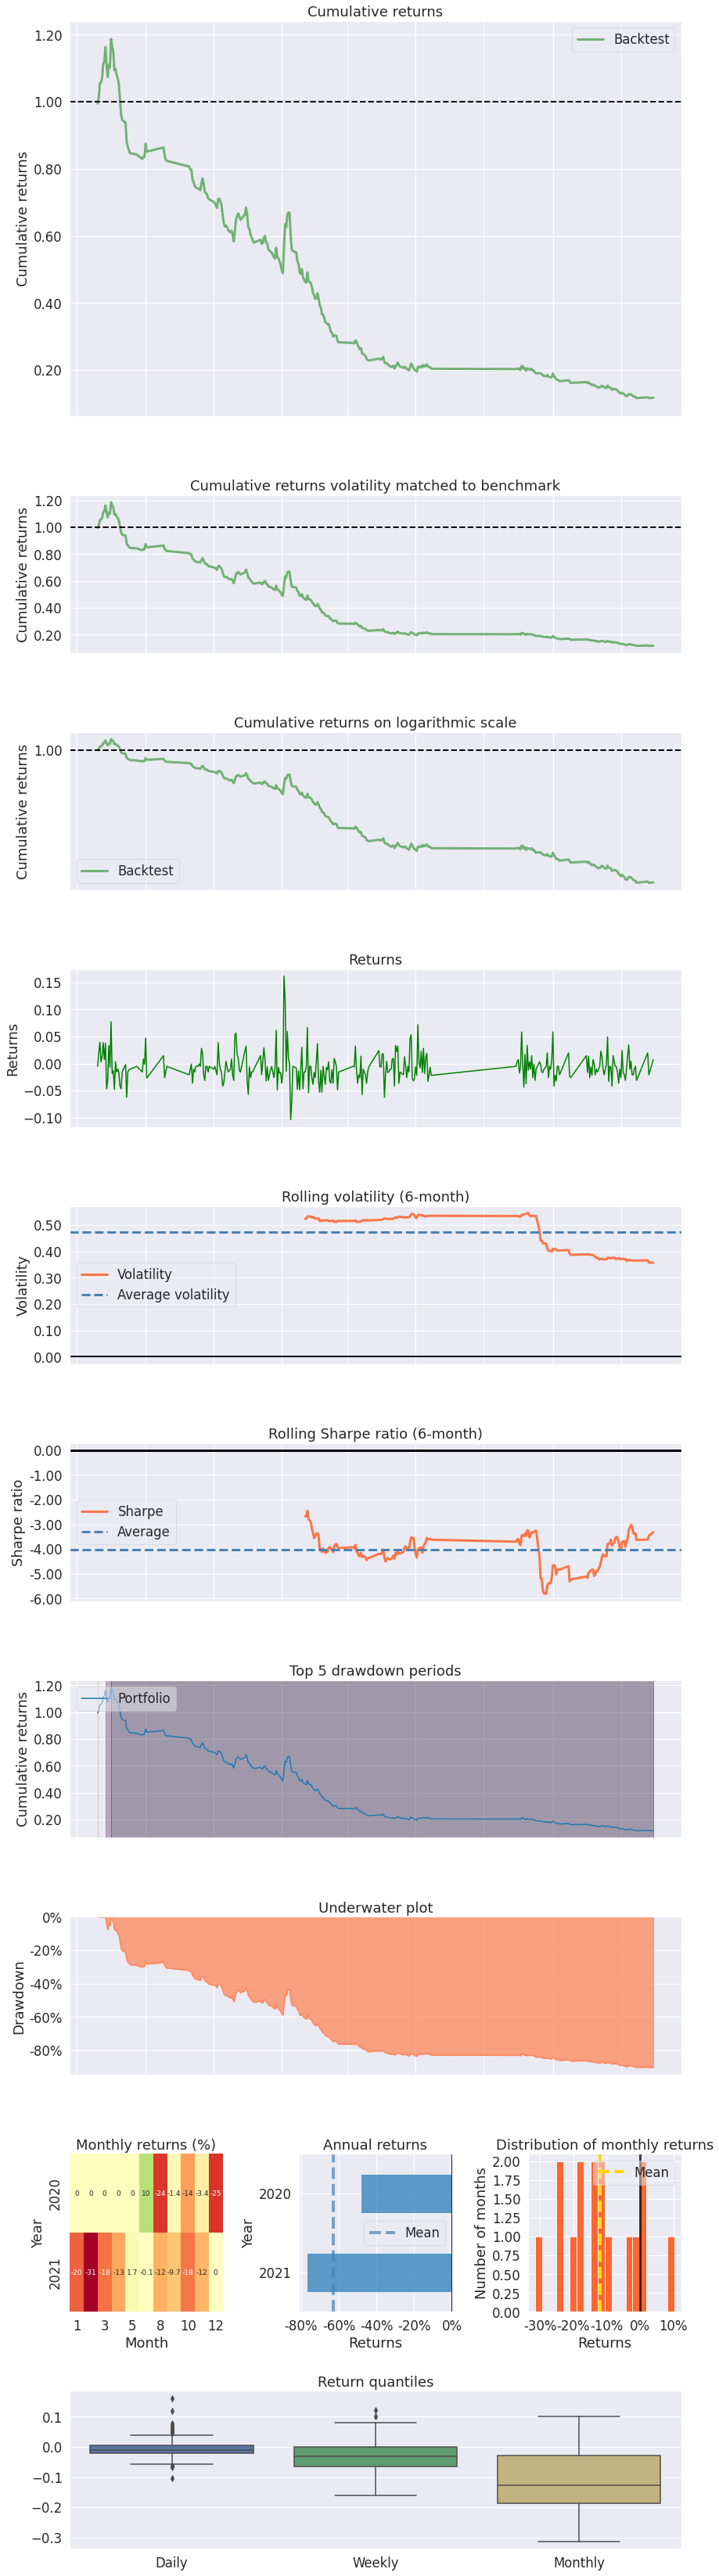

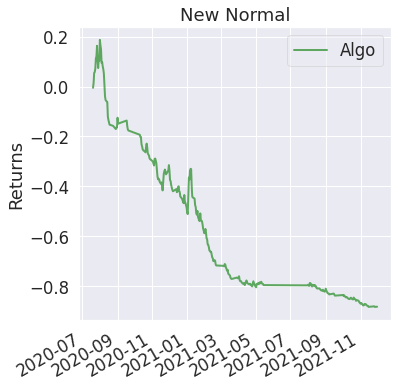

In [689]:
%load_ext autoreload
%autoreload 2
# [!!! NOTE !!!] before using pyfolio we need to change a line in the code
# Change this `valley = np.argmin(underwater)  # end of the period`
# To this valley = underwater.index[np.argmin(underwater)]
# in file pyfolio/timeseries.py

import pyfolio
pyfolio.create_full_tear_sheet(returns_report.groupby(by='close_date').sum()['return'], transactions=pf_transactions)

<AxesSubplot:xlabel='close_date'>

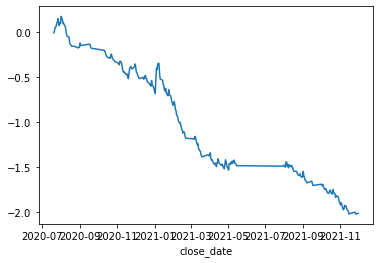

In [649]:
returns_report.groupby(by='close_date').sum()['return'].cumsum().plot()

,open,high,low,close,hourly_9,hourly_21,hourly_34,hourly_50,hourly_89,hourly_100,...,4_hour_150,4_hour_200,12_hour_9,12_hour_21,12_hour_34,12_hour_50,12_hour_89,12_hour_100,12_hour_150,12_hour_200
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,131.45,131.54,131.01,131.19,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:07:00,131.19,131.36,131.16,131.33,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:14:00,131.33,131.36,131.25,131.30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:21:00,131.30,131.44,131.26,131.30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:28:00,131.27,131.74,131.26,131.56,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 23:27:00,4658.93,4661.86,4640.02,4643.22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 23:34:00,4643.23,4648.97,4633.19,4646.69,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 23:41:00,4646.70,4655.76,4635.68,4638.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
df.resample(str(7*144) + "min").agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last'})

,open,high,low,close
date,,,,
2019-01-01 00:00:00,131.45,136.00,130.00,133.03
2019-01-01 16:48:00,133.00,147.30,131.00,144.99
2019-01-02 09:36:00,144.98,155.37,144.35,151.37
2019-01-03 02:24:00,151.36,153.64,143.11,145.20
2019-01-03 19:12:00,145.19,154.80,143.54,149.34
...,...,...,...,...
2021-11-27 21:36:00,4068.16,4130.78,3976.75,4072.46
2021-11-28 14:24:00,4072.47,4375.00,3964.00,4338.32
2021-11-29 07:12:00,4338.31,4458.92,4276.89,4444.53


In [170]:
df = pd.read_csv(
    HISTORICAL_DATA_FILE)

# Sort out the Binance timestamp
df['date'] = df['date'].apply(lambda x: pd.Timestamp(x * 1000 * 1000))
# df['date'] = df['date'].apply(lambda x: pd.Timestamp(x))
df.index = df['date']
# Filter out columns
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

In [175]:
alternate_dfs

{'hourly':               open     high     low    close
 date                                        
 2019-01-31  131.45   159.26  100.91   106.44
 2026-01-31  106.47  4868.00   86.00  4630.26,
 '4_hour':               open     high     low    close
 date                                        
 2019-01-31  131.45   159.26  100.91   106.44
 2047-01-31  106.47  4868.00   86.00  4630.26,
 '12_hour':               open     high     low    close
 date                                        
 2019-01-31  131.45   159.26  100.91   106.44
 2122-04-30  106.47  4868.00   86.00  4630.26}

In [609]:
import pyfolio

/Users/blagovestvelev/.pyenv/versions/3.10.0/envs/notebook/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [615]:
pyfolio.create_full_tear_sheet(returns['TOTAL_RETURN'])

/Users/blagovestvelev/.pyenv/versions/3.10.0/envs/notebook/lib/python3.10/site-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2020-07-20
End date,2021-11-30
Total months,110
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,971.6%
Sharpe ratio,-23.91
Calmar ratio,-1.00
Stability,NaN
Max drawdown,-100.0%


IndexError: index -1 is out of bounds for axis 0 with size 0

In [614]:
returns = report[['close_time', 'TOTAL_RETURN']]
returns.index = returns['close_time']
returns['TOTAL_RETURN']


close_time
2020-07-20 19:21:00   -0.005197
2020-07-21 10:41:00    0.014599
2020-07-22 21:34:00    0.034395
2020-07-22 22:20:00    0.054183
2020-07-23 04:05:00    0.048984
                         ...   
2021-11-30 19:18:00   -1.995090
2021-11-30 20:04:00   -2.000289
2021-11-30 20:50:00   -2.005489
2021-11-30 21:36:00   -2.010689
2021-11-30 23:54:00   -2.015889
Name: TOTAL_RETURN, Length: 2330, dtype: float64

In [616]:
pyfolio.utils.extract_rets_pos_txn_from_zipline?